In [1]:
import numpy as np 
import pandas as pd 
import re, itertools, json, os, random, contractions, nltk, warnings
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob as TB
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xgb
from wordcloud import WordCloud
from collections import Counter
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
from datetime import datetime
from bs4 import BeautifulSoup
from textblob import Word

/home/ankushraut/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def sentiment_analyzer(x):
    if x<0.3:
        return -1
    elif x>0.55:
        return 1
    else:
        return 0

In [3]:
training = pd.read_csv('training_data (1).csv')
training.dropna(inplace = True)

In [4]:
bag_of_words_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bag_of_words = bag_of_words_vectorizer.fit_transform(training.text)

In [5]:
booster = xgb.Booster({'nthread':4}) #init model
booster.load_model("prediction_model.model") # load data

In [11]:
nykaa_insta = pd.read_csv('nykaa_insta.csv')

In [12]:
nykaa_insta.head()

,review
0,Hey! Please check your DM I've been trying to ...
1,"Hello, @mynykaa. Please check your DM! I had a..."
2,❤️❤️
3,"@anuswarup14 Hey, you can click on the link in..."
4,"Hey, Nykaa do you ship in Canada, I really wa..."


In [20]:
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"@(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [21]:
HT = hashtag_extract(nykaa_insta['review'])
HT = sum(HT,[])

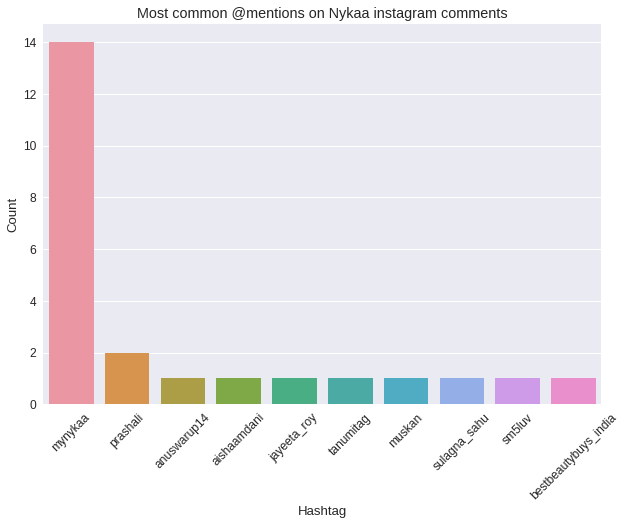

In [23]:
a = nltk.FreqDist(HT)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags  

sns.set(font_scale=1.2)
d = d.nlargest(columns="Count", n = 10) 

plt.figure(figsize=(10,7))
plt.title('Most common @mentions on Nykaa instagram comments')
sns.barplot(data=d, x= "Hashtag", y = "Count")
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

In [24]:
lem = WordNetLemmatizer()

def strip_html(text):
    try:
        soup = BeautifulSoup(text, "html.parser")
        y = soup.get_text()
    except ValueError:
        pass
    return y

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    try:
        text = strip_html(text)
        try:
            text = remove_between_square_brackets(text)
        except ValueError:
            pass
    except ValueError:
        pass
    return text

def replace_contractions(text):
    return contractions.fix(text)

In [25]:
nykaa_insta.dropna(inplace = True)
nykaa_insta = nykaa_insta.reset_index(drop = True)

In [26]:
nykaa_insta.review = nykaa_insta.review.map(lambda x: denoise_text(x))        
nykaa_insta.review = nykaa_insta.review.map(lambda x: replace_contractions(x))
nykaa_insta.review = nykaa_insta.review.str.replace('[^\w\s]',' ')
nykaa_insta.review = nykaa_insta.review.apply(lambda x: " ".join(x.lower() for x in x.split()))

Overall wordcloud for HnG insta comments


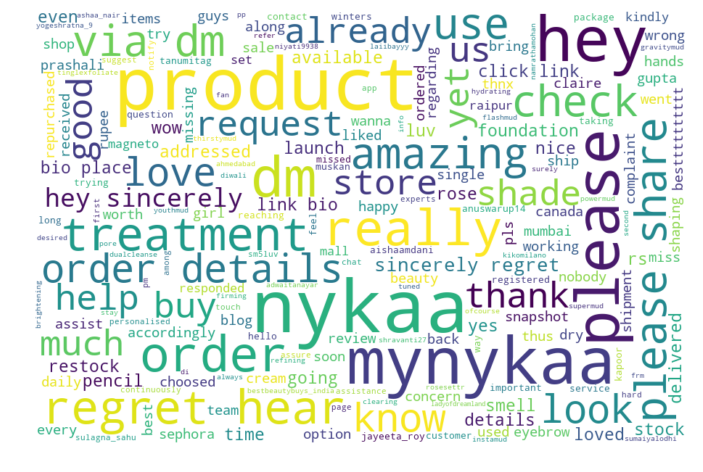

In [27]:
stopset = stopset = set(stopwords.words('english'))
nykaa_insta_words = ' '.join([text for text in nykaa_insta.review])
nykaa_insta_words = ' '.join([w for w in nykaa_insta_words.split() if not w in stopset])
wordcloud = WordCloud(background_color = "white",width=900, height=600, random_state=21, max_font_size=100).generate(nykaa_insta_words)
print('Overall wordcloud for HnG insta comments')
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [28]:
nykaa_polarity = list(np.round(booster.predict(xgb.DMatrix(bag_of_words_vectorizer.transform(nykaa_insta.review))),2))
nykaa_subjectivity = [np.round(TB(nykaa_insta.review[i]).sentiment[1],2) for i in range(len(nykaa_insta))]
nykaa_sentiment = [sentiment_analyzer(x) for x in nykaa_polarity]

In [29]:
nykaa_insta['sentiment'] = pd.DataFrame({'sentiment':nykaa_sentiment})
nykaa_insta['polarity'] = pd.DataFrame({'polarity':nykaa_polarity})
nykaa_insta['subjectivity'] = pd.DataFrame({'subjectivity':nykaa_subjectivity})

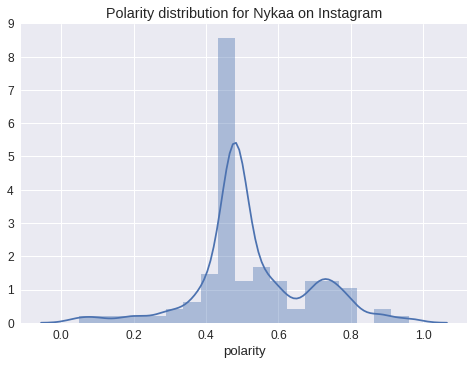

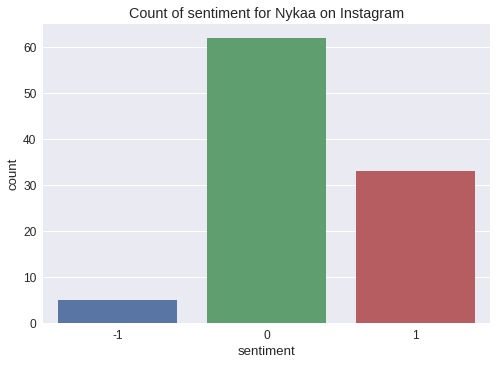

In [30]:
plt.title('Polarity distribution for Nykaa on Instagram')
sns.distplot(nykaa_insta.polarity)
plt.show()

plt.title('Count of sentiment for Nykaa on Instagram')
sns.countplot(nykaa_insta.sentiment)
plt.show()

Positive wordcloud for Nykaa Instagram comments


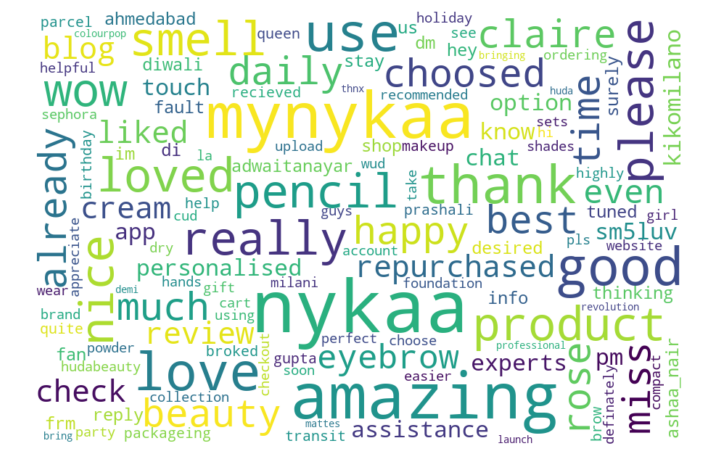

In [33]:
nykaa_insta_positive = nykaa_insta[nykaa_insta.sentiment == 1]
nykaa_insta_negative = nykaa_insta[nykaa_insta.sentiment == -1]
nykaa_insta_neutral = nykaa_insta[nykaa_insta.sentiment == 0]

nykaa_insta_words_positive = ' '.join([text for text in nykaa_insta_positive.review])
nykaa_insta_words_positive = ' '.join([w for w in nykaa_insta_words_positive.split() if not w in stopset])
try:
    print('Positive wordcloud for Nykaa Instagram comments')
    wordcloud = WordCloud(background_color="white",width=900, height=600, random_state=21, max_font_size=100).generate(nykaa_insta_words_positive)

    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
except ValueError:
    pass


Negative wordcloud for Nykaa Instagram comments


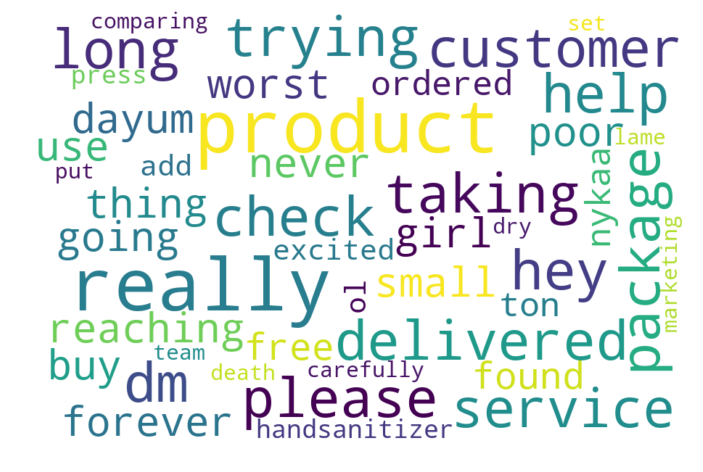

In [34]:
nykaa_insta_words_negative = ' '.join([text for text in nykaa_insta_negative.review])
nykaa_insta_words_negative = ' '.join([w for w in nykaa_insta_words_negative.split() if not w in stopset])
try:
    print('Negative wordcloud for Nykaa Instagram comments')
    wordcloud = WordCloud(background_color="white",width=900, height=600, random_state=21, max_font_size=100).generate(nykaa_insta_words_negative)
    plt.figure(figsize=(12,8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
except ValueError:
    pass

Neutral wordcloud for Nykaa Instagram comments


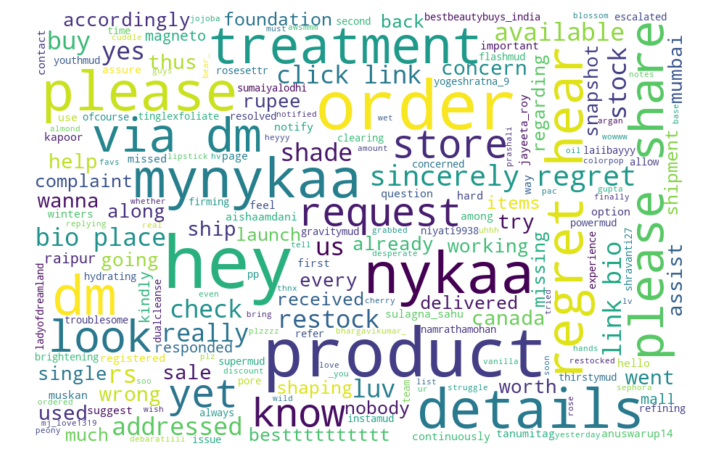

In [35]:
nykaa_insta_words_neutral = ' '.join([text for text in nykaa_insta_neutral.review])
nykaa_insta_words_neutral = ' '.join([w for w in nykaa_insta_words_neutral.split() if not w in stopset])
try:
    print('Neutral wordcloud for Nykaa Instagram comments')
    wordcloud = WordCloud(background_color="white",width=900, height=600, random_state=21, max_font_size=100).generate(nykaa_insta_words_neutral)

    plt.figure(figsize=(12,8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
except ValueError:
    pass

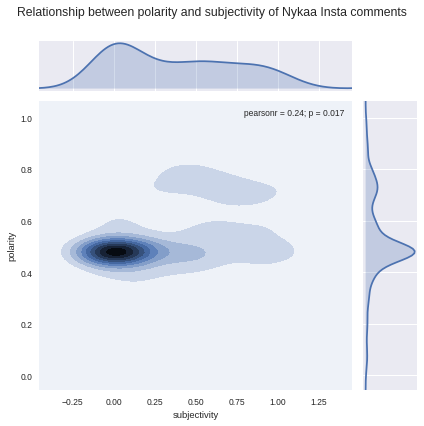

In [36]:
sns.set(font_scale=0.85)
g = sns.jointplot(x="subjectivity", y="polarity", data=nykaa_insta,kind='kde')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Relationship between polarity and subjectivity of Nykaa Insta comments")
plt.show()

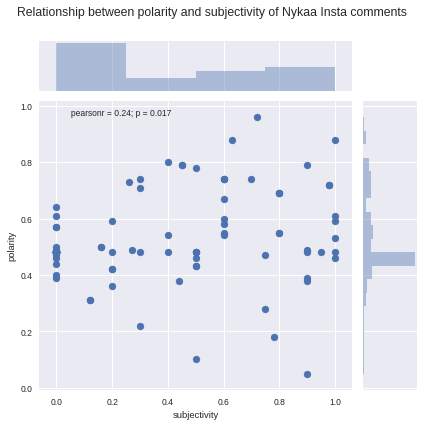

In [37]:
sns.set(font_scale=0.85)
g = sns.jointplot(x="subjectivity", y="polarity", data=nykaa_insta)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Relationship between polarity and subjectivity of Nykaa Insta comments")
plt.show()

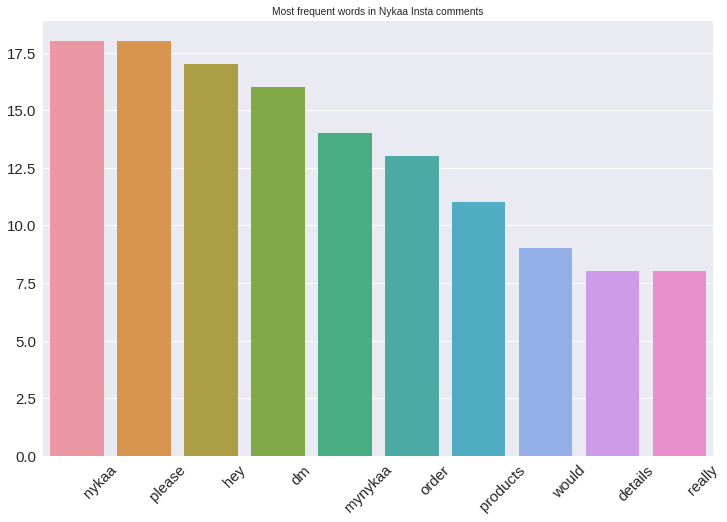

In [38]:
nykaa_insta_dictionary = list(nykaa_insta.review)
def joinStrings(dictionary):
    return ' '.join(string for string in dictionary)

nykaa_insta_dictionary = joinStrings(nykaa_insta_dictionary)

nykaa_insta_dictionary = [w for w in nykaa_insta_dictionary.split() if not w in stopset]
counts = dict(Counter(nykaa_insta_dictionary).most_common(10))

labels, values = zip(*counts.items())
indSort = np.argsort(values)[::-1]

labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.figure(figsize = (12,8))
plt.title('Most frequent words in Nykaa Insta comments')
b=sns.barplot(indexes, values)
b.tick_params(labelsize=15)
plt.xticks(indexes + bar_width, labels)
plt.xticks(rotation=45)
plt.show()

In [39]:
nykaa_insta.to_excel('nykaa_insta_comments.xlsx', index = False)

In [40]:
nykaa_website = pd.read_excel('nykaa_website_reviews.xlsx')

In [41]:
nykaa_twitter = pd.read_excel('nykaa_twitter_reviews.xlsx')

In [42]:
nykaa_complete = pd.concat([nykaa_website.drop(labels = ['category', 'Time Bin','time'], axis = 1), nykaa_insta,
                           nykaa_twitter])

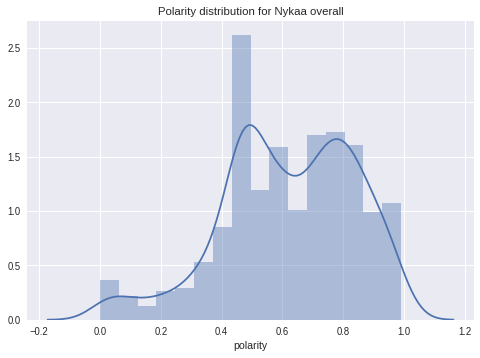

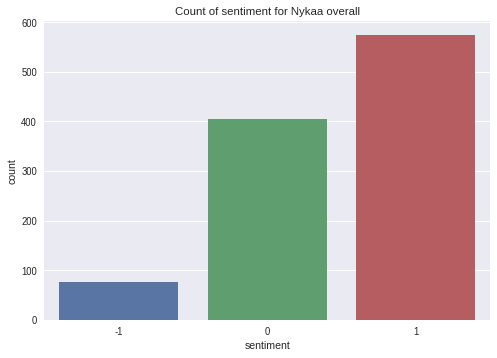

In [43]:
sns.set(font_scale = 0.95)
plt.title('Polarity distribution for Nykaa overall')
sns.distplot(nykaa_complete.polarity)
plt.show()

plt.title('Count of sentiment for Nykaa overall')
sns.countplot(nykaa_complete.sentiment)
plt.show()

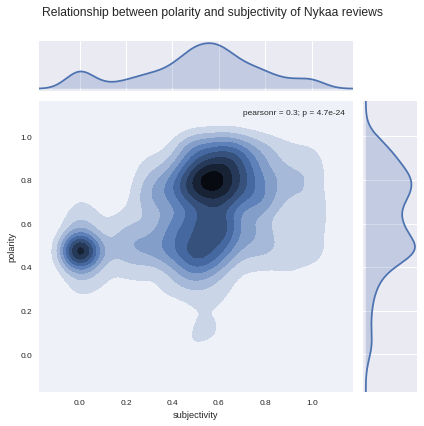

In [44]:
sns.set(font_scale=0.84)
g = sns.jointplot(x="subjectivity", y="polarity", data=nykaa_complete,kind='kde')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Relationship between polarity and subjectivity of Nykaa reviews")
plt.show()

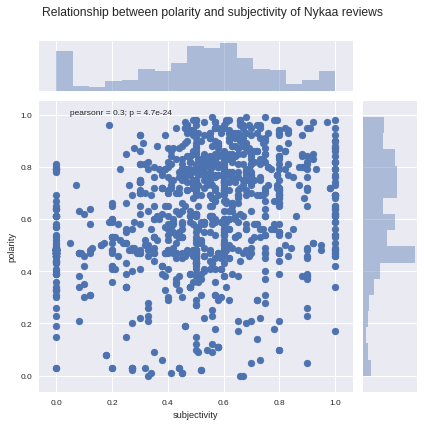

In [45]:
sns.set(font_scale=0.84)
g = sns.jointplot(x="subjectivity", y="polarity", data=nykaa_complete)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Relationship between polarity and subjectivity of Nykaa reviews")
plt.show()